# example: Keras 1D convolutional neural network on SUSY data

# SUSY Data Set

- <https://archive.ics.uci.edu/ml/datasets/SUSY>
- <http://arxiv.org/abs/1402.4735>

The SUSY Data Set is a classification problem to distinguish between a signal process which produces supersymmetric particles and a background process which does not. In the data, the first column is the class label (1 for signal, 0 for background), followed by 18 features (8 low-level features and 10 high-level features):

- lepton 1 pT
- lepton 1 eta
- lepton 1 phi
- lepton 2 pT
- lepton 2 eta
- lepton 2 phi
- missing energy magnitude
- missing energy phi
- MET_rel
- axial MET
- M_R
- M_TR_2
- R
- MT2
- S_R
- M_Delta_R
- dPhi_r_b
- cos(theta_r1)

This data has been produced by MadGraph5 Monte Carlo simulations of 8 TeV proton collisions, with showering and hadronisation performed by Pythia 6 and detector response simulated by Delphes. The first 8 features are kinematic properties measured by simulated particle detectors. The next 10 features are functions of the first 8 features; they are high-level features derived by physicists to help discriminate between the two classes. There are 46% positive examples in the SUSY data set. The features were standardised over the entire training/testing sets with mean zero and standard deviation one, except for those features with values strictly greater than zero; these were scaled such that the mean value was one.

In [1]:
from keras.datasets import mnist
from keras import activations
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import plot_model
from matplotlib import gridspec
from matplotlib.ticker import NullFormatter, NullLocator, MultipleLocator
from scipy import stats
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from vis.utils import utils
from vis.visualization import visualize_activation
from vis.visualization import visualize_saliency
import datetime
import keras
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import talos as ta
sns.set_palette('husl')
sns.set(style = 'ticks')

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [17, 14]

In [3]:
df = pd.read_csv(
    "SUSY_100k.csv",
    names = [
        "classification",
        "lepton_1_pT",
        "lepton_1_eta",
        "lepton_1_phi",
        "lepton_2_pT",
        "lepton_2_eta",
        "lepton_2_phi",
        "missing_energy_magnitude",
        "missing_energy_phi",
        "MET_rel",
        "axial_MET",
        "M_R",
        "M_TR_2",
        "R",
        "MT2",
        "S_R",
        "M_Delta_R",
        "dPhi_r_b",
        "cos_theta_r1"
    ]
)
df_raw = df
df.head()

,classification,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


## dataset characteristics, feature histograms and hierarchically-clustered correlations

In [4]:
df.describe()

,classification,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,0.45975,1.002520,-0.001214,0.001130,0.998765,-0.002327,0.001986,1.002132,-0.001027,1.001774e+00,0.001874,1.001381,1.000968,0.998835,1.002564,1.000301,1.002018,0.996392,2.255094e-01
std,0.49838,0.682332,1.005256,1.003296,0.649669,1.004957,1.000790,0.876802,1.001608,8.878220e-01,1.005287,0.624153,0.584931,0.471350,0.860436,0.616290,0.624171,0.436301,1.977076e-01
min,0.00000,0.255649,-2.102649,-1.734744,0.428590,-2.059240,-1.733849,0.000709,-1.727112,9.238942e-07,-10.582791,0.272967,0.009538,0.018478,0.000000,0.074357,0.004657,0.000008,2.388670e-07
25%,0.00000,0.563566,-0.764006,-0.868199,0.595844,-0.775816,-0.864801,0.480474,-0.865236,3.711455e-01,-0.491849,0.589816,0.620144,0.649552,0.169395,0.598758,0.515733,0.685564,6.905427e-02
50%,0.00000,0.792447,-0.001697,0.000985,0.798784,-0.003995,0.002508,0.775232,-0.013274,8.020215e-01,-0.078552,0.828958,0.879155,0.933930,0.906571,0.835261,0.917300,1.089616,1.681940e-01
75%,1.00000,1.209686,0.762437,0.872140,1.160556,0.769450,0.867590,1.207878,0.869245,1.373204e+00,0.352210,1.213489,1.222236,1.279828,1.615310,1.209476,1.385430,1.366626,3.303397e-01
max,1.00000,12.620587,2.101403,1.734717,13.107124,2.059317,1.734670,13.959188,1.740672,1.450629e+01,14.342724,13.969072,13.200295,5.335464,12.791473,14.024200,10.329440,1.591660,1.000000e+00


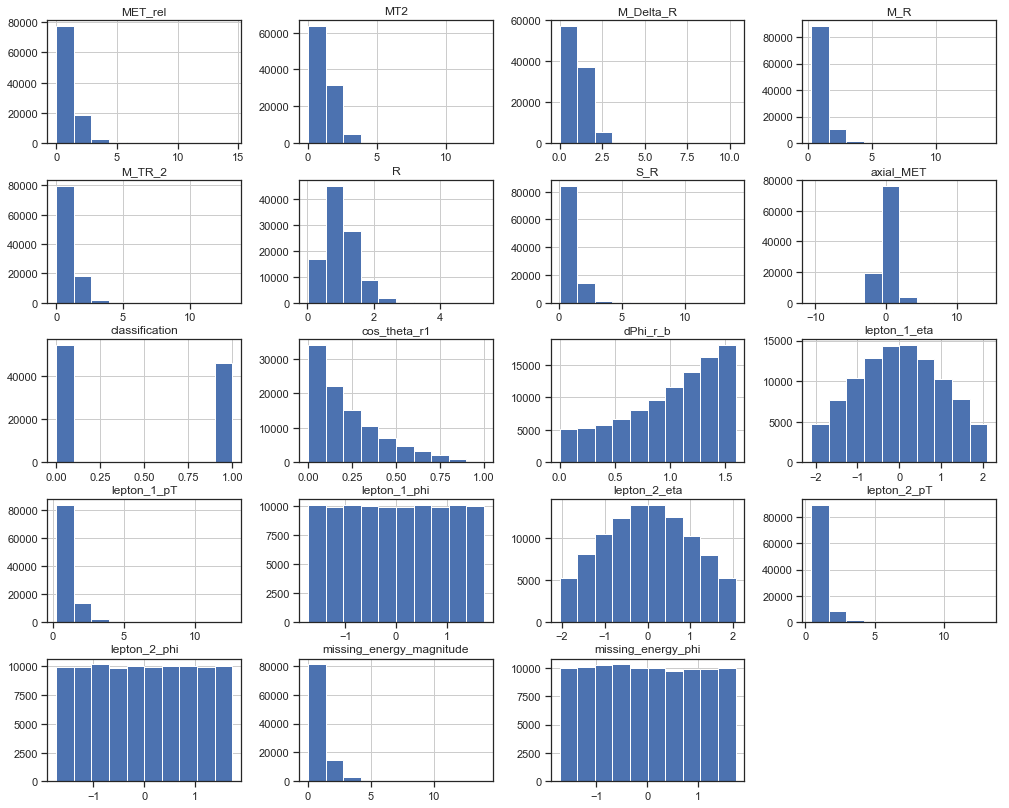

In [5]:
df.hist();

In [6]:
#correlations
_df = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).to_frame()
_df.columns = _df.columns.astype(str).tolist()
_df.reset_index(inplace=True)
_df.columns = ["feature_1", "feature_2", "correlation"]
_df.query("correlation != 1").head()

,feature_1,feature_2,correlation
19,M_R,S_R,0.980831
20,S_R,M_R,0.980831
21,M_R,lepton_1_pT,0.849700
22,lepton_1_pT,M_R,0.849700
23,MT2,M_Delta_R,0.811086


In [7]:
_df.query("correlation != 1").tail()

,feature_1,feature_2,correlation
356,MT2,lepton_1_eta,0.000038
357,lepton_2_eta,lepton_1_phi,0.000035
358,lepton_1_phi,lepton_2_eta,0.000035
359,axial_MET,lepton_1_phi,0.000019
360,lepton_1_phi,axial_MET,0.000019


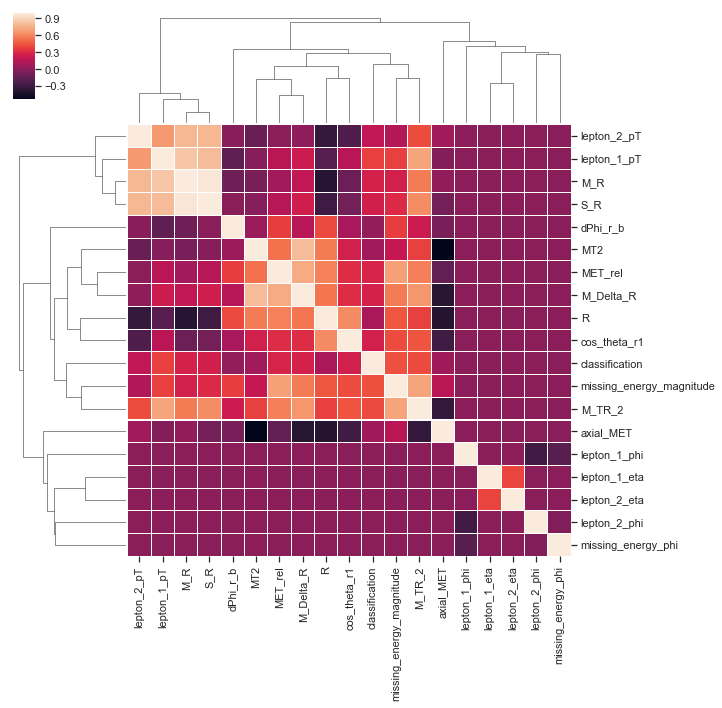

In [8]:
#hierarchically-clustered correlations
plot = sns.clustermap(df.corr(), linewidths=0.1)
hierarchically_clustered_features = plot.data2d.columns
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)

Reorder the columns according to the hierarchical clustering.

In [9]:
df = df[hierarchically_clustered_features.tolist()]
df.head()

,lepton_2_pT,lepton_1_pT,M_R,S_R,dPhi_r_b,MT2,MET_rel,M_Delta_R,R,cos_theta_r1,classification,missing_energy_magnitude,M_TR_2,axial_MET,lepton_1_phi,lepton_1_eta,lepton_2_eta,lepton_2_phi,missing_energy_phi
0,1.157156,0.972861,1.921887,1.932632,1.367815,1.145621,0.810061,0.994464,0.410772,0.040714,0.0,0.567765,0.889637,-0.252552,1.176225,0.653855,-1.739873,-0.874309,-0.175000
1,0.506102,1.667973,1.045977,0.448410,1.321893,0.000000,0.012955,0.205356,0.481928,0.377584,1.0,3.475464,0.568051,3.775174,-1.225171,0.064191,-0.338939,1.672543,-1.219136
2,0.451719,0.444840,0.526283,0.603498,1.135454,2.024308,1.831248,1.562374,1.587535,0.180910,1.0,1.219918,0.941514,-0.431385,-0.709972,-0.134298,-1.613871,-0.768661,0.504026
3,0.448959,0.381256,0.569386,0.761215,1.492257,1.551914,3.046260,1.715464,1.582217,0.090719,1.0,2.033060,1.015211,-1.005285,0.693152,-0.976145,0.891753,-0.677328,1.533041
4,1.589283,1.309996,1.179295,1.083158,1.154854,0.000000,0.589204,0.043429,0.728563,0.094859,1.0,1.087562,0.968218,1.365479,-0.676259,-0.690089,-0.693326,0.622907,-0.381742


In [10]:
#sns.pairplot(df, hue = "classification");

In [11]:
df['labels'] = df['classification'].astype('category').cat.codes
x = df.drop(columns = ['classification', 'labels']).values.astype('float32')
y = df['classification']
num_classes = len(y.unique())
y_raw = y # non-categorical

x = np.asarray(x)
y = np.asarray(y)

x = x.reshape(len(x), 18, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True)

# Convert class vectors to binary class matrices using 1 hot encoding.
# 0 ---> 1, 0
# 1 ---> 0, 1
y_cat   = keras.utils.to_categorical(y, len(y_raw.unique()))
y_train = keras.utils.to_categorical(y_train, len(y_raw.unique()))
y_test  = keras.utils.to_categorical(y_test,  len(y_raw.unique()))

In [12]:
# Define a callback class which is to be passed to the model fitting function
# as an element of a list of possible callbacks.
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self, batch, logs = {}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

class NBatchLogger(keras.callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()
        
history = AccuracyHistory()

  0%|          | 0/12 [00:00<?, ?it/s]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.5, 'activation': 'relu', 'dense_1': 200, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.45827940451304117
test accuracy: 0.7866666666666666


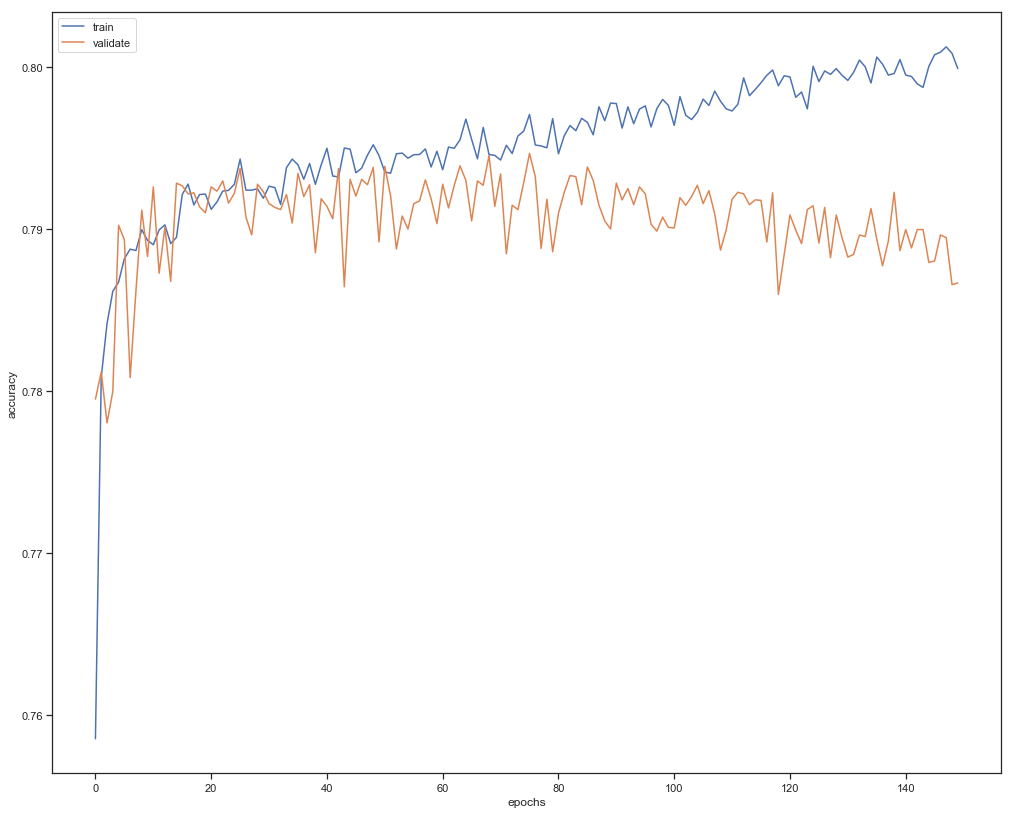

  8%|▊         | 1/12 [02:32<28:01, 152.88s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.5, 'activation': 'relu', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4495777744293213
test accuracy: 0.7926666666666666


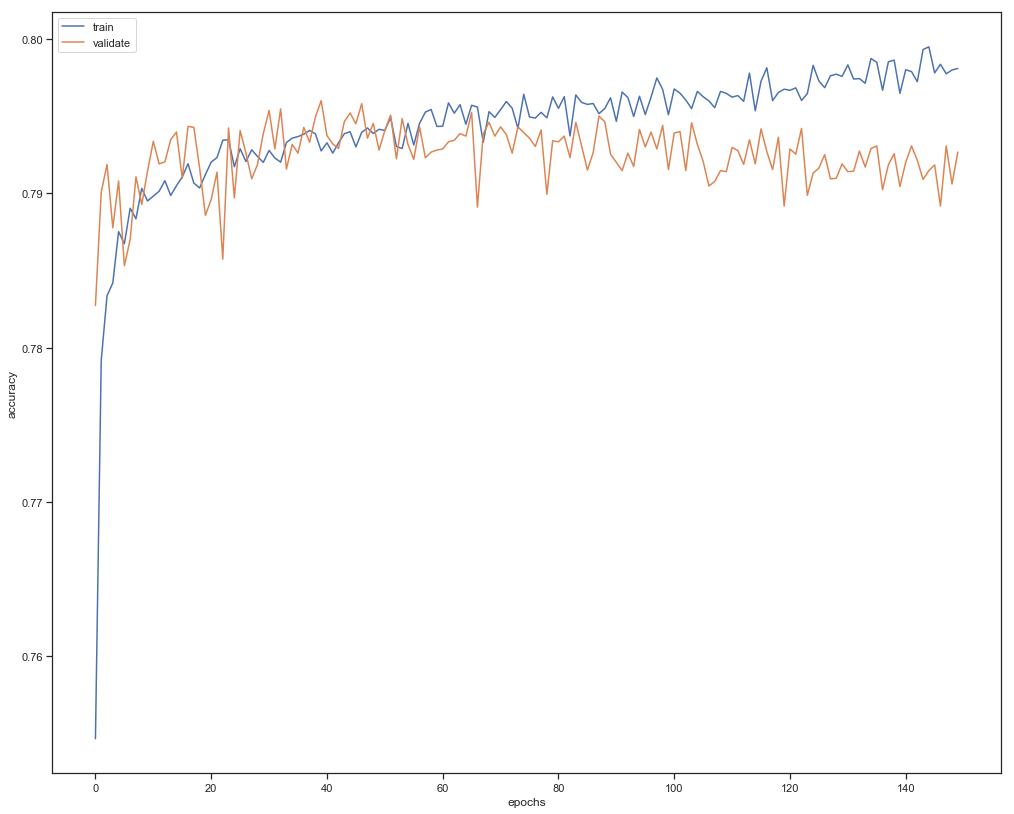

 17%|█▋        | 2/12 [05:05<25:26, 152.70s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.5, 'activation': 'tanh', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4583046275615692
test accuracy: 0.7839


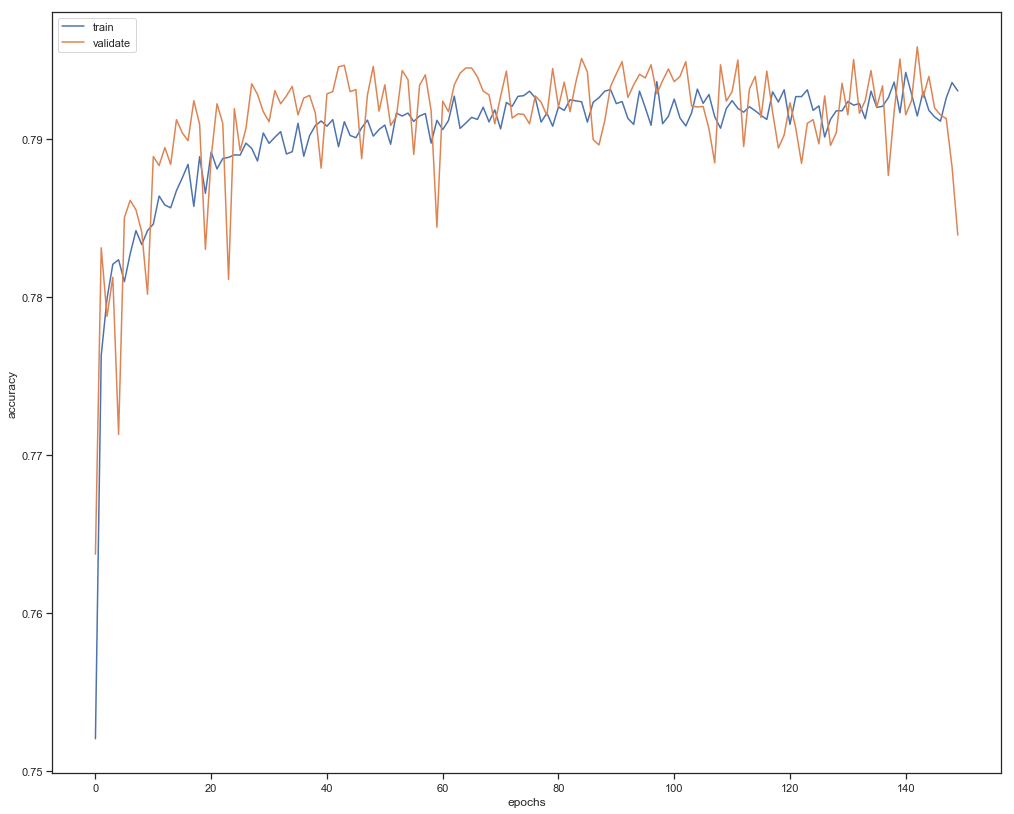

 25%|██▌       | 3/12 [07:37<22:54, 152.69s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.1, 'activation': 'tanh', 'dense_1': 200, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.46256920466423035
test accuracy: 0.786


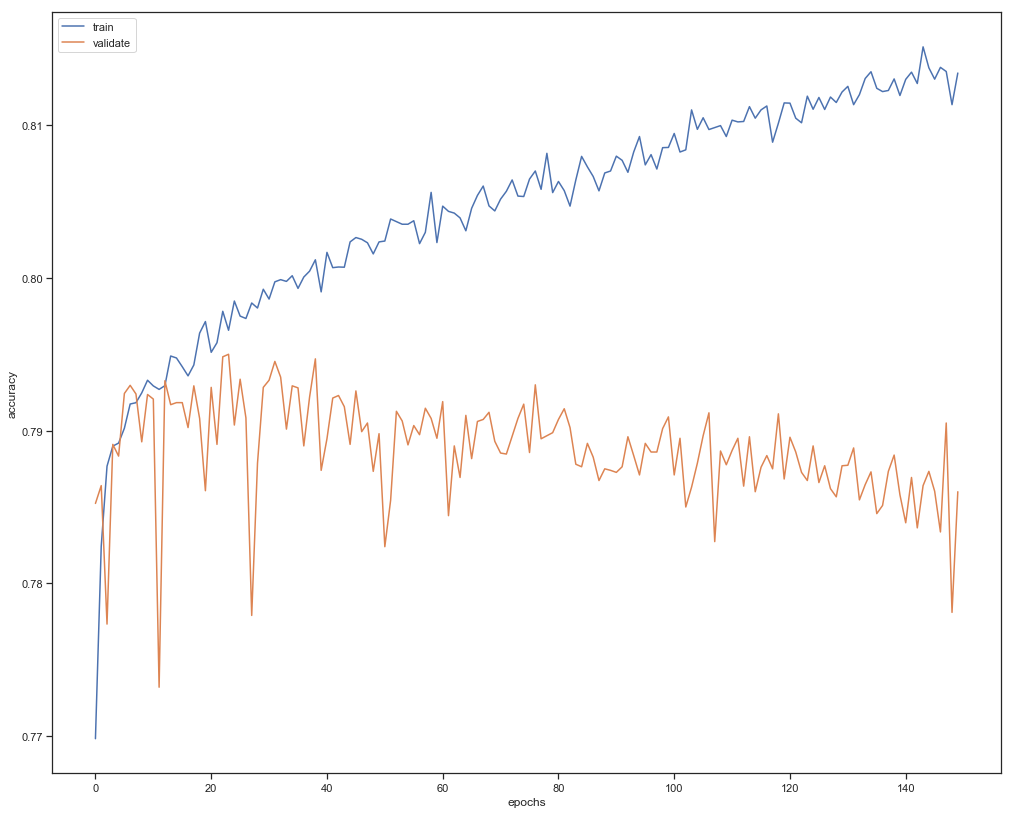

 33%|███▎      | 4/12 [10:10<20:21, 152.67s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.5, 'activation': 'tanh', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.44787605504989625
test accuracy: 0.7917666666666666


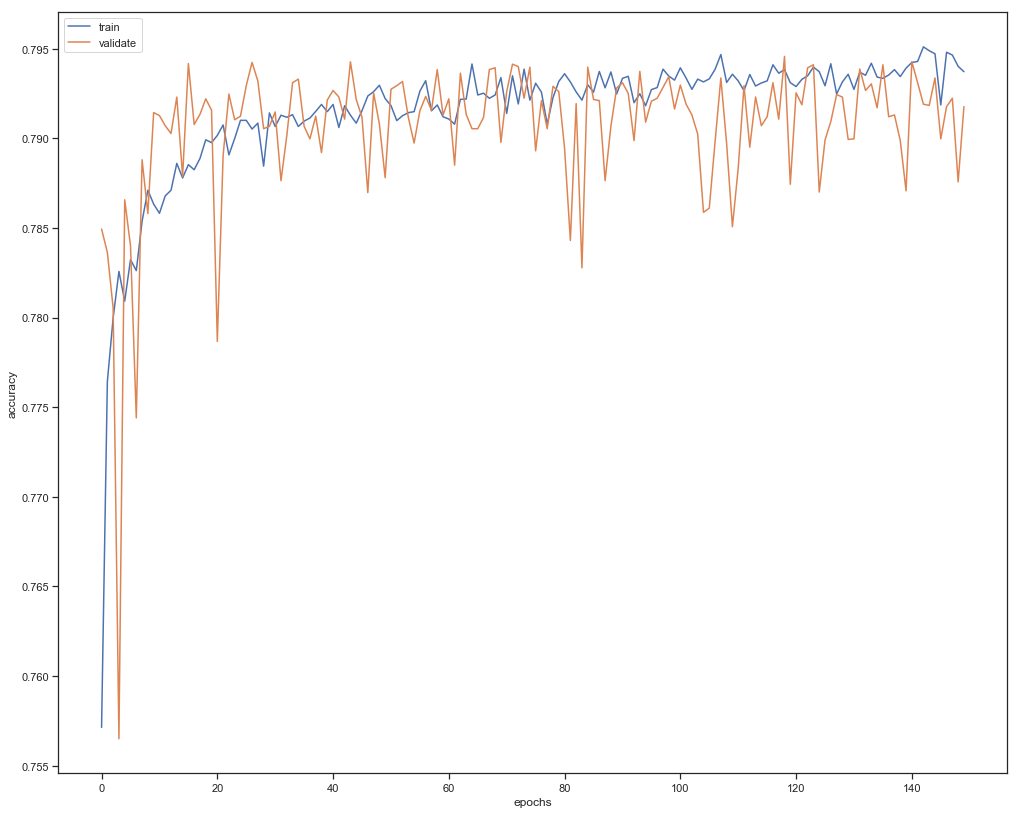

 42%|████▏     | 5/12 [12:42<17:48, 152.59s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.5, 'activation': 'tanh', 'dense_1': 200, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4454361425558726
test accuracy: 0.7929333333333334


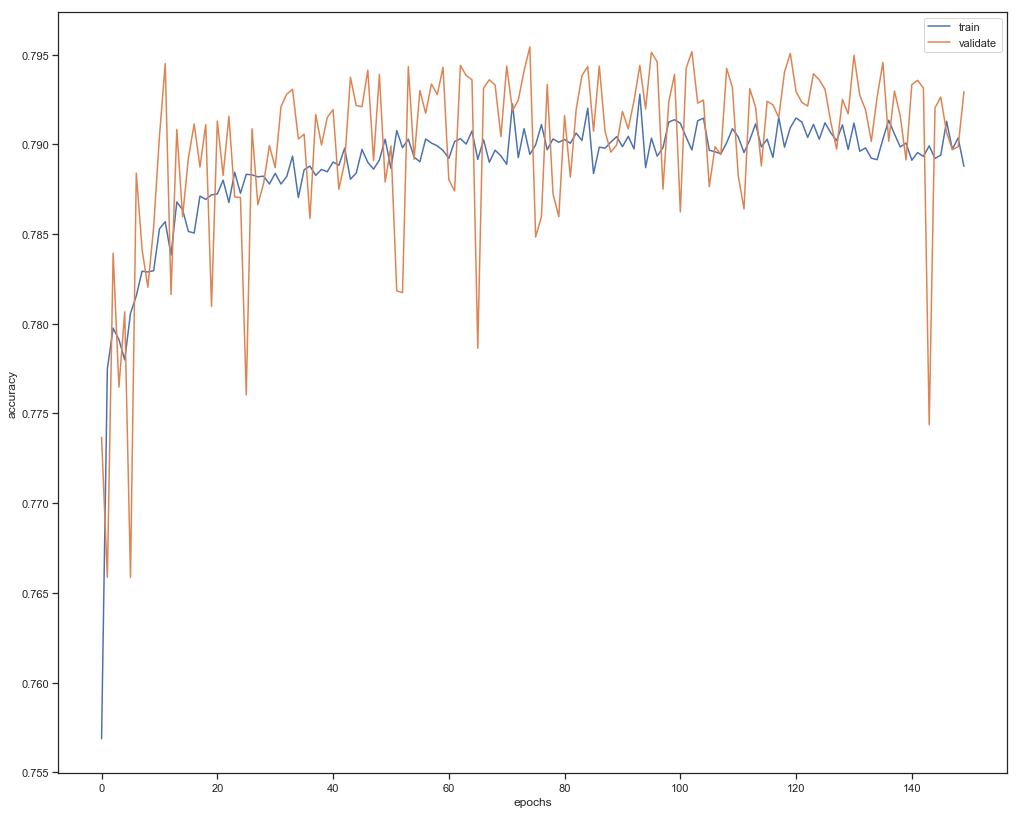

 50%|█████     | 6/12 [15:15<15:15, 152.55s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.1, 'activation': 'tanh', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4683560916900635
test accuracy: 0.7814666666666666


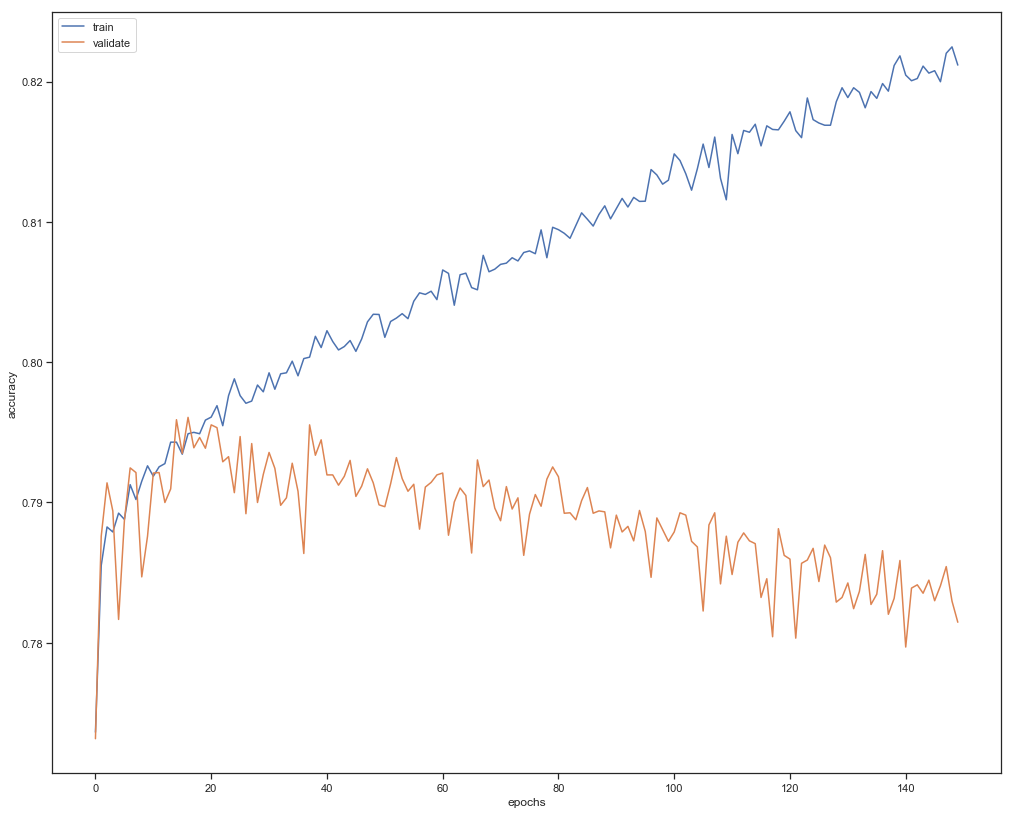

 58%|█████▊    | 7/12 [17:48<12:43, 152.64s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.1, 'activation': 'tanh', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.45746827324231465
test accuracy: 0.7854333333333333


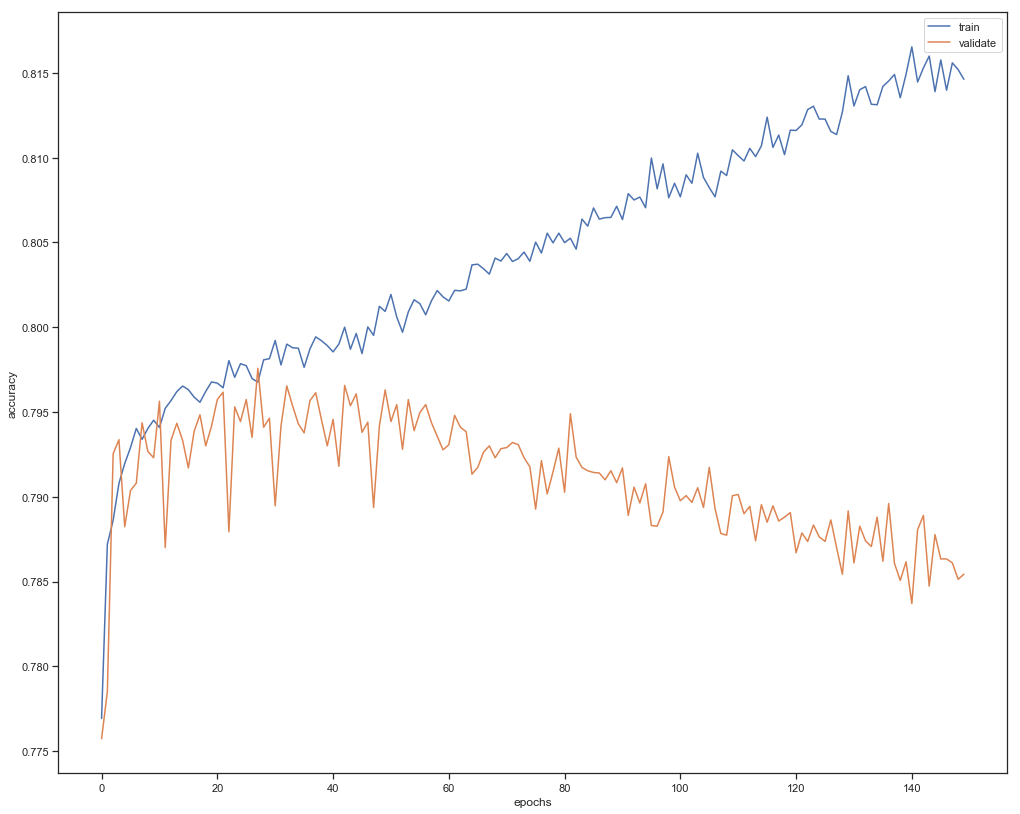

 67%|██████▋   | 8/12 [20:20<10:10, 152.65s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.1, 'activation': 'relu', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.49834777868588764
test accuracy: 0.7866666666666666


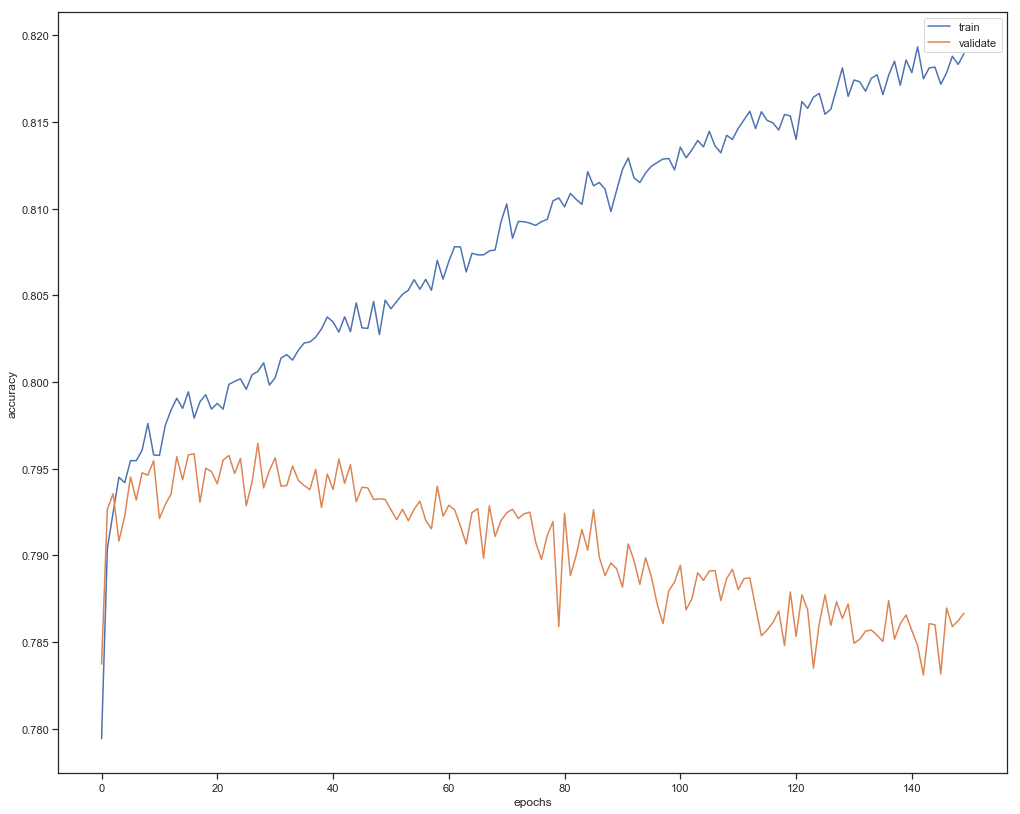

 75%|███████▌  | 9/12 [22:55<07:39, 153.14s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.1, 'activation': 'relu', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.5802502238591513
test accuracy: 0.7726


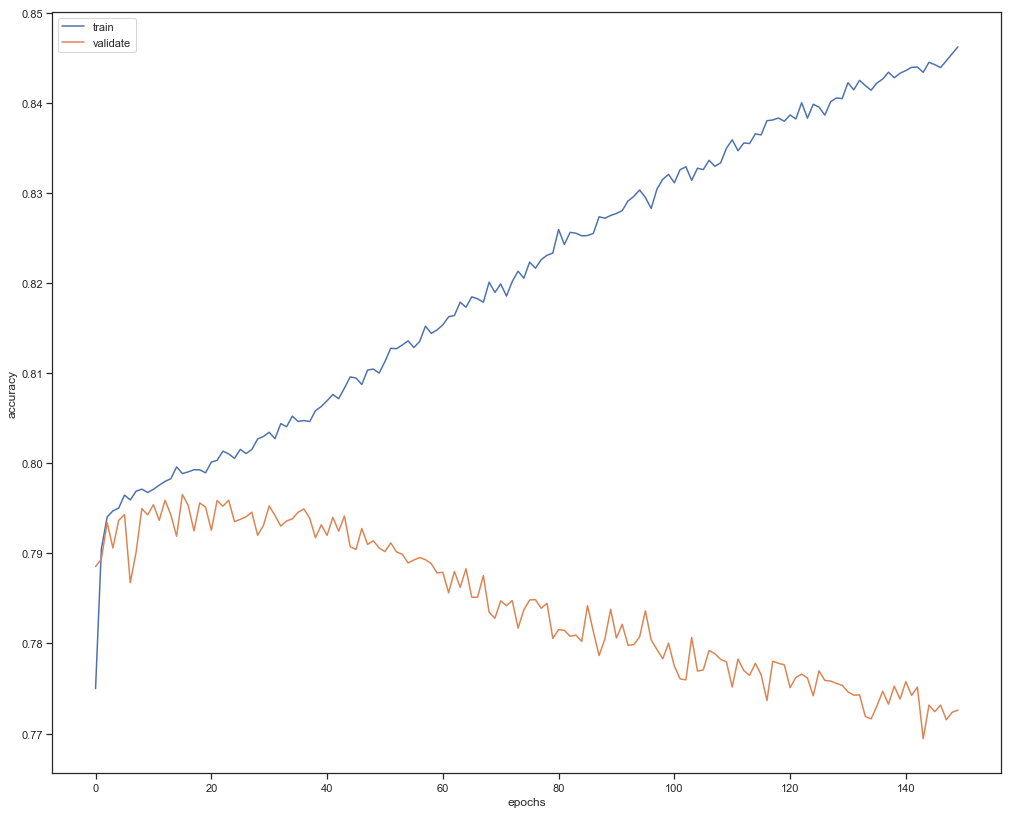

 83%|████████▎ | 10/12 [25:28<05:06, 153.18s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.5, 'activation': 'relu', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4423878820737203
test accuracy: 0.7946666666666666


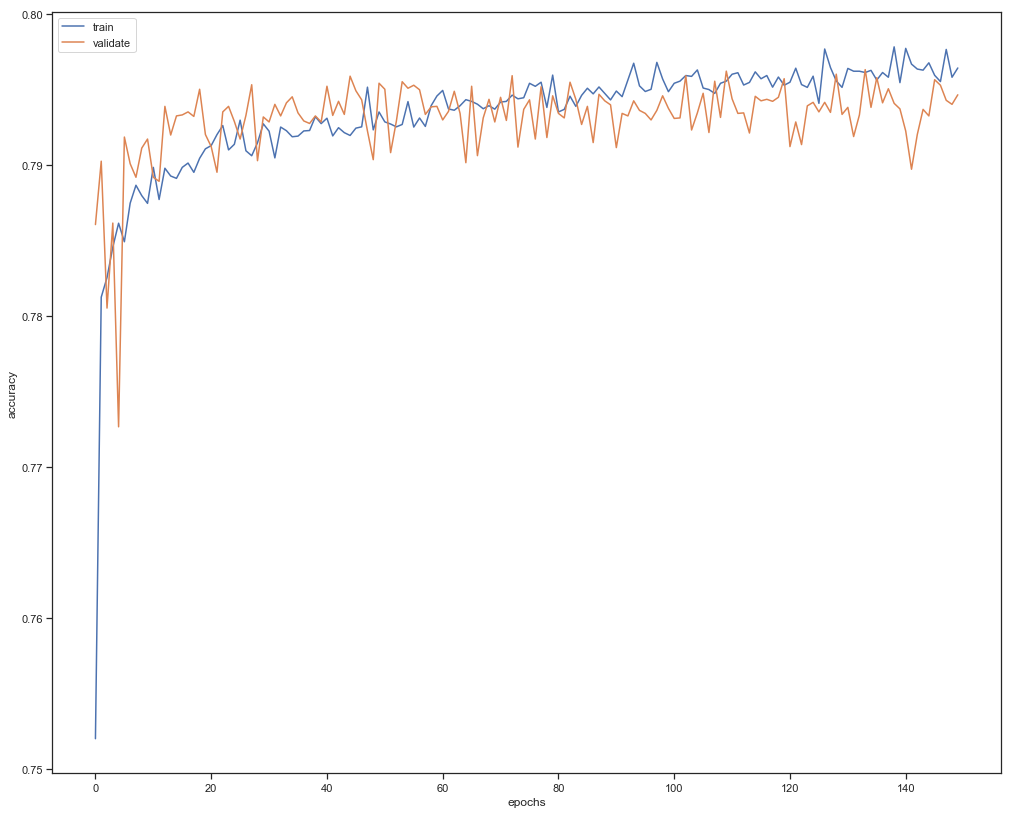

 92%|█████████▏| 11/12 [28:01<02:33, 153.24s/it]

{'batch_size': 256, 'epochs': 150, 'dropout': 0.1, 'activation': 'relu', 'dense_1': 200, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.8505471102714539
test accuracy: 0.7496333333333334


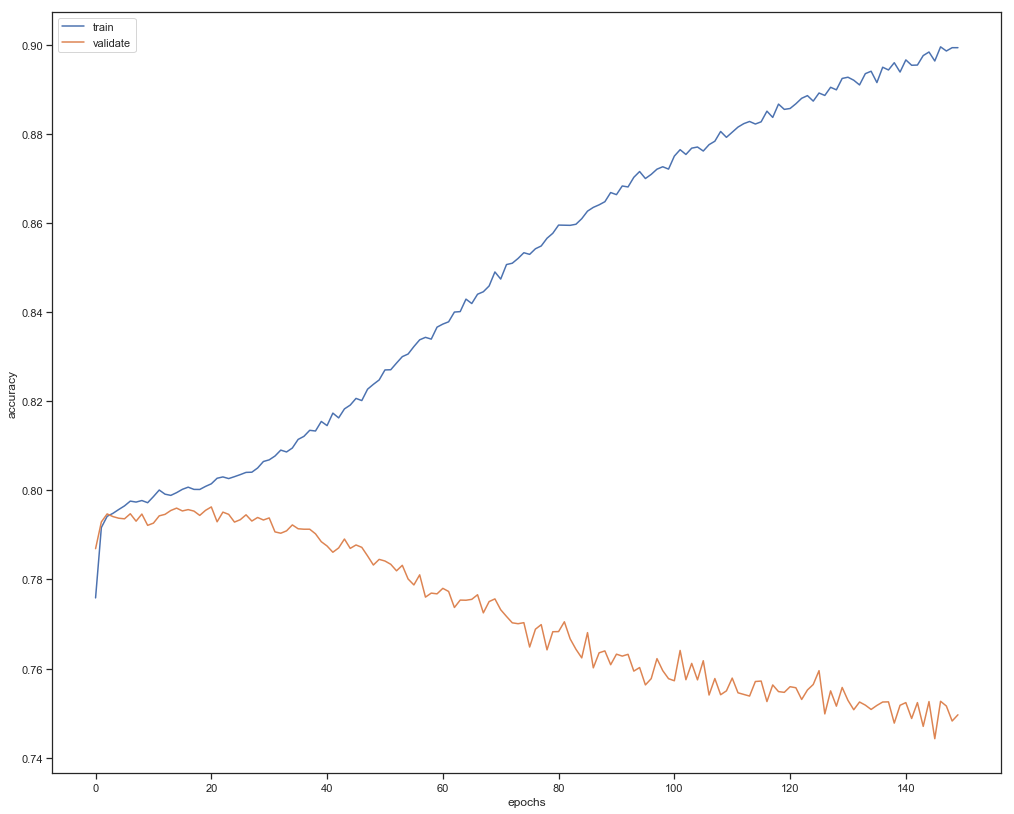

100%|██████████| 12/12 [30:34<00:00, 153.18s/it]

CPU times: user 46min 4s, sys: 3min 39s, total: 49min 44s
Wall time: 30min 34s


In [13]:
%%time
parameters = {
    'batch_size': [256],
    'epochs'    : [150],
    'dropout'   : [0.1, 0.5],
    'activation': ['tanh', 'relu'],
    'dense_1'   : [50, 100, 200],
    'optimizer' : ['nadam'],
    'losses'    : ['categorical_crossentropy'],
}

def hmodel_convolutional(
    x_train,
    y_train,
    x_test,
    y_test,
    parameters = parameters
    ):
    model = Sequential()
    model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = parameters['activation']))
    model.add(Dropout(rate = parameters['dropout']))
    model.add(MaxPooling1D(pool_size = (2), strides = (2)))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = parameters['activation']))
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Flatten())
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    model.add(Dropout(rate = parameters['dropout']))
    model.add(Dense(num_classes,                                    activation = 'softmax'))
    model.compile(
        loss      = parameters['losses'],
        optimizer = parameters['optimizer'],
        metrics   = ['accuracy']
    )
    #filepath = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H%M%SZ") + ".png"
    #plot_model(model, to_file = filepath)
    #plot_model(model, to_file = "model.png")
    #print(model.summary())
    out = model.fit(
        x_train,
        y_train,
        batch_size      = parameters['batch_size'],
        epochs          = parameters['epochs'],
        verbose         = False,
        validation_data = [x_test, y_test],
        callbacks       = [history]
    )
    score = model.evaluate(x_test, y_test, verbose = False)
    print('test loss:', score[0])
    print('test accuracy:', score[1])
    plt.plot(history.acc, label='train')
    plt.plot(history.val_acc, label='validate')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    return out, model

h = ta.Scan(
    x                = x,
    y                = y_cat,
    params           = parameters,
    dataset_name     = 'SUSY',
    experiment_no    = '1',
    model            = hmodel_convolutional,
    grid_downsample  = 1,
    #reduction_method = None
    reduction_method = 'correlation',
    print_params     = True
)

In [14]:
r = ta.Reporting(h)
r.data.sort_values(by = ['val_acc'], ascending = False)

,round_epochs,val_loss,val_acc,loss,acc,batch_size,epochs,dropout,activation,dense_1,optimizer,losses
7,150,0.437797,0.797567,0.401389,0.816529,256,150,0.1,tanh,50,nadam,categorical_crossentropy
9,150,0.437926,0.796533,0.337714,0.846214,256,150,0.1,relu,100,nadam,categorical_crossentropy
8,150,0.438132,0.796467,0.387751,0.819343,256,150,0.1,relu,50,nadam,categorical_crossentropy
10,150,0.439887,0.796333,0.440265,0.797843,256,150,0.5,relu,50,nadam,categorical_crossentropy
11,150,0.438314,0.796267,0.230333,0.899486,256,150,0.1,relu,200,nadam,categorical_crossentropy
6,150,0.439331,0.796067,0.388871,0.822471,256,150,0.1,tanh,100,nadam,categorical_crossentropy
1,150,0.440876,0.796000,0.436022,0.799486,256,150,0.5,relu,100,nadam,categorical_crossentropy
2,150,0.440478,0.795800,0.446954,0.794186,256,150,0.5,tanh,100,nadam,categorical_crossentropy
5,150,0.441350,0.795433,0.450223,0.792800,256,150,0.5,tanh,200,nadam,categorical_crossentropy
3,150,0.441062,0.795000,0.404451,0.815129,256,150,0.1,tanh,200,nadam,categorical_crossentropy


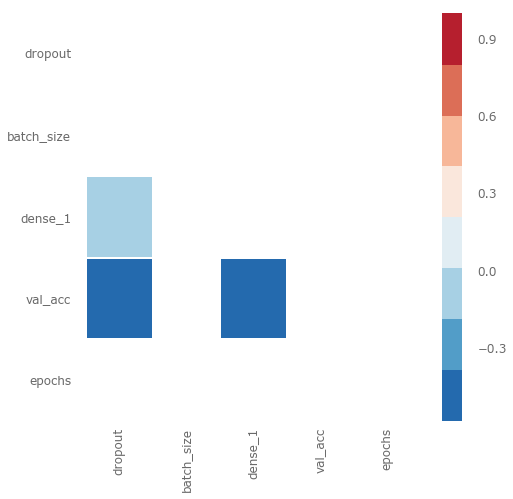

In [15]:
r.plot_corr()

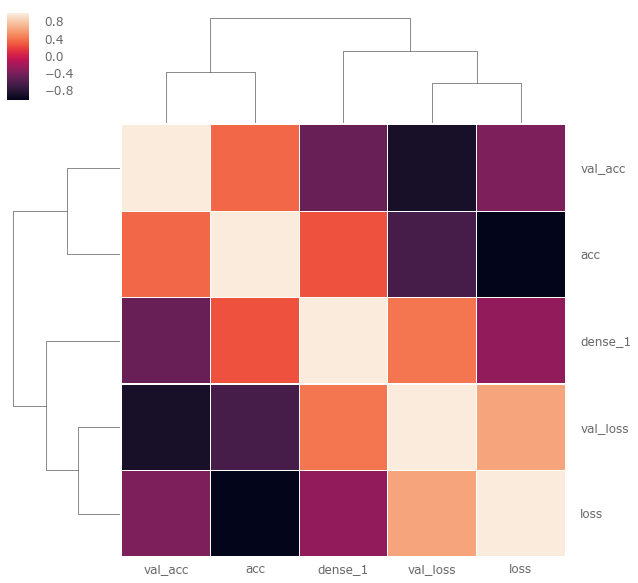

In [16]:
_df = r.data[['val_loss', 'val_acc', 'loss', 'acc', 'dense_1']]
plot = sns.clustermap(_df.corr(), linewidths=0.1)
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)

## based on the hyperparameter scan, a single model is selected and examined

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             3104      
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               48300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
__________

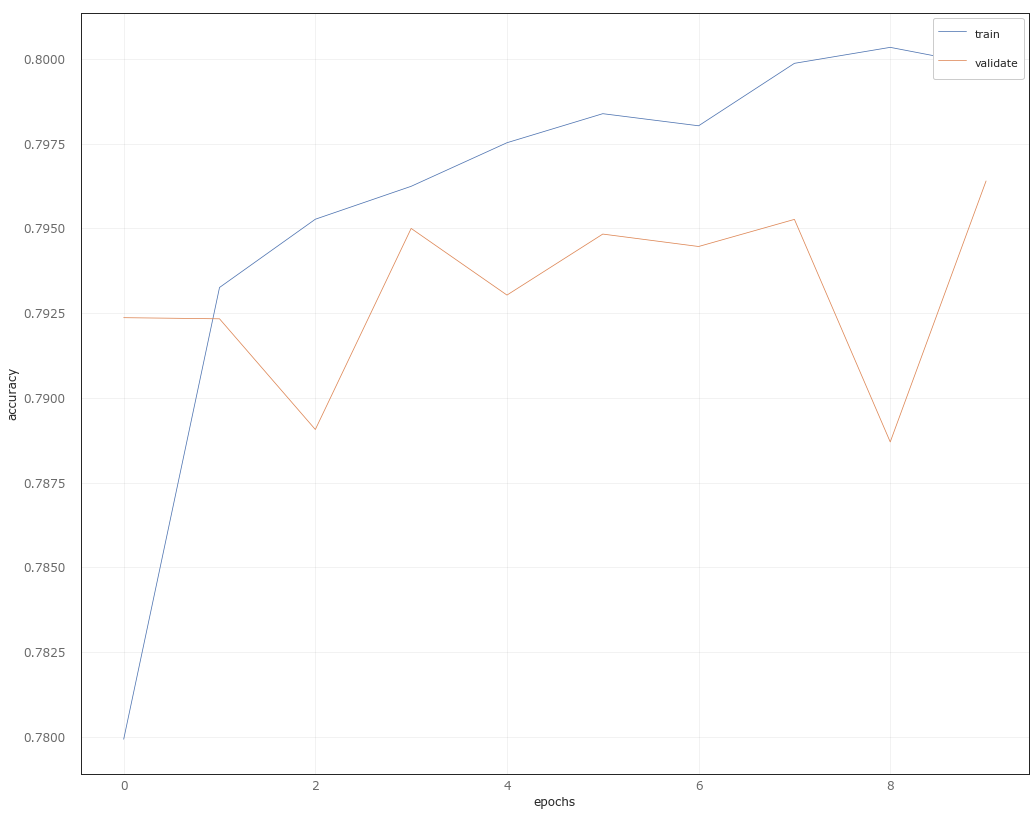

CPU times: user 16.7 s, sys: 1.53 s, total: 18.2 s
Wall time: 10.8 s


In [17]:
%%time
model = Sequential()
model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = 'relu'))
model.add(MaxPooling1D(pool_size = (2), strides = (2)))
model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Flatten())
model.add(Dense(300,                                            activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Dense(300,                                            activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(num_classes,                                    activation = 'softmax', name = "preds"))
model.compile(loss = "categorical_crossentropy", optimizer = "nadam", metrics = ['accuracy'])
#plot_model(model, to_file = "model.png")
model.summary()

epochs     = 10
batch_size = 256

model.fit(
    x_train,
    y_train,
    batch_size      = batch_size,
    epochs          = epochs,
    verbose         = True,
    validation_data = (x_test, y_test),
    callbacks       = [history]
)

score = model.evaluate(x_test, y_test, verbose = False)

print('test loss:', score[0])
print('test accuracy:', score[1])
plt.plot(history.acc, label='train')
plt.plot(history.val_acc, label='validate')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## swap softmax top layer for linear (for ROC and activation maximization)

In [18]:
layer_idx = utils.find_layer_idx(model, 'preds')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

## ROC, AUC

In [19]:
y_pred = model.predict(x_test)
y_test_non_categorical = np.argmax(y_test, axis=1)
y_pred_non_categorical = np.argmax(y_pred, axis=1)
fpr, tpr, thresholds = roc_curve(y_test_non_categorical, y_pred[:,1])
auc_data = auc(fpr, tpr)

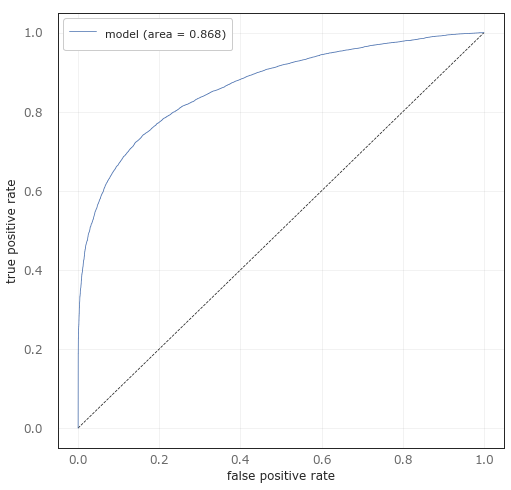

In [20]:
plt.rcParams["figure.figsize"] = [8, 8]

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='model (area = {:.3f})'.format(auc_data))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
#plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## activation maximization

In [21]:
filter_idx_background = 0
filter_idx_signal     = 1

am = pd.DataFrame()
am['features']              = df.drop(["classification", "labels"], axis=1).columns.tolist()
am['activation_background'] = visualize_activation(model, layer_idx, filter_indices=filter_idx_background)
am['activation_signal']     = visualize_activation(model, layer_idx, filter_indices=filter_idx_signal)
am

,features,activation_background,activation_signal
0,lepton_2_pT,153,95
1,lepton_1_pT,151,117
2,M_R,163,90
3,S_R,164,101
4,dPhi_r_b,167,84
5,MT2,145,112
6,MET_rel,144,103
7,M_Delta_R,124,124
8,R,125,115
9,cos_theta_r1,96,148


### activation maximization for background

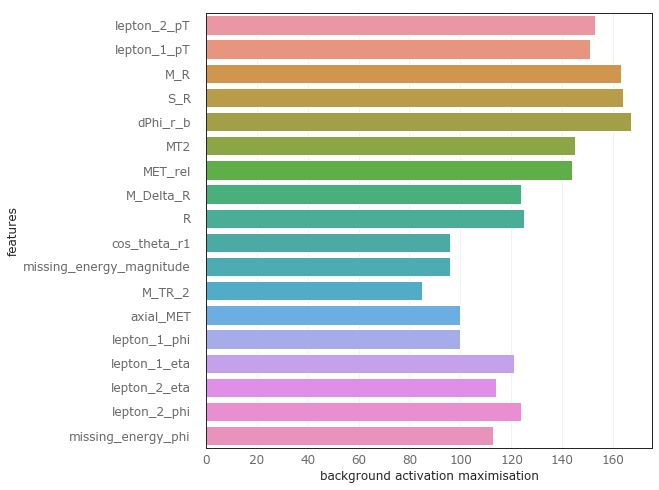

In [22]:
sns.barplot(am["activation_background"], am["features"]);
plt.xlabel('background activation maximisation')
plt.show();

### activation maximization for signal

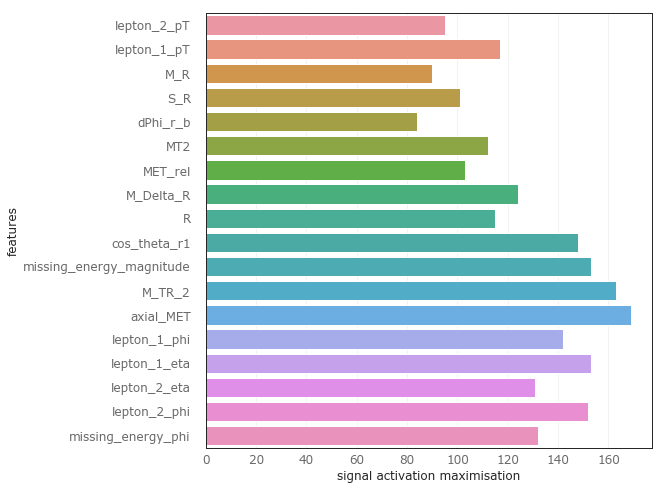

In [23]:
sns.barplot(am["activation_signal"], am["features"]);
plt.xlabel('signal activation maximisation')
plt.show();

### activation maximization for signal and background

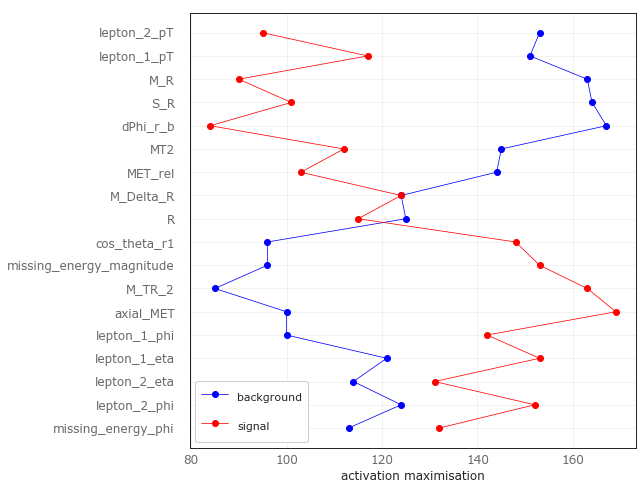

In [24]:
plt.plot(am['activation_background'], am['features'], marker='o', color='blue',  label = 'background')
plt.plot(am['activation_signal'],     am['features'], marker='o', color='red', label = 'signal')
plt.gca().invert_yaxis()
plt.xlabel('activation maximisation')
plt.legend(loc = 'best')
plt.show();

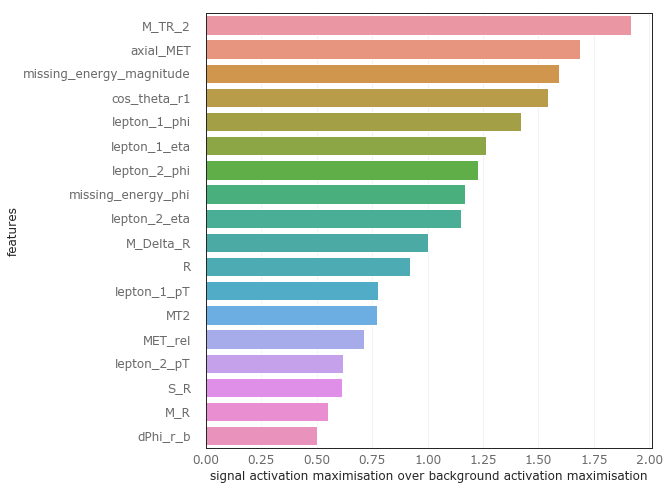

In [25]:
am['activation_signal_over_activation_background'] = am['activation_signal'] / am['activation_background']
_am = am.sort_values(by = ['activation_signal_over_activation_background'], ascending = False)
sns.barplot(_am['activation_signal_over_activation_background'], _am['features']);
plt.xlabel('signal activation maximisation over background activation maximisation')
plt.show;

## saliency

Iterate over a number of test cases, calculate the saliency map for each case and collate the results in a DataFrame.

In [26]:
number_of_saliency_maps = 100

try:
    y_test_non_categorical = y_test_non_categorical.tolist()
except:
    pass
columns = df.drop(columns = ['labels', 'classification']).columns.tolist()
columns.insert(0, "classification")

# calculate input-specific saliency maps of class signal
filter_idx = filter_idx_signal
rows = []
for i in list(range(0, number_of_saliency_maps)):
    grads = visualize_saliency(model, layer_idx, filter_indices=filter_idx, seed_input=x_test[i], backprop_modifier='guided')
    _ = [y_test_non_categorical[i]]
    _.extend(grads.tolist())
    rows.append(_)

sm_s = pd.DataFrame(rows, columns=columns)
sm_s.head()

,classification,lepton_2_pT,lepton_1_pT,M_R,S_R,dPhi_r_b,MT2,MET_rel,M_Delta_R,R,cos_theta_r1,missing_energy_magnitude,M_TR_2,axial_MET,lepton_1_phi,lepton_1_eta,lepton_2_eta,lepton_2_phi,missing_energy_phi
0,0,0.000000,0.186148,0.227010,0.318761,0.423380,0.164004,0.126272,0.067563,0.057085,0.420517,0.021841,0.408412,0.515260,0.308295,0.999999,0.300220,0.112349,0.010042
1,1,0.000000,0.115585,0.096698,0.200622,0.237709,0.164916,0.056782,0.017586,0.243099,0.452126,0.007920,0.245869,0.117359,0.093311,0.358213,0.999999,0.310521,0.009448
2,0,0.009631,0.106478,0.176064,0.000000,0.226706,0.623163,0.051345,0.009822,0.999999,0.373053,0.137370,0.008275,0.165585,0.304618,0.842534,0.458949,0.030617,0.005738
3,1,0.000000,0.027895,0.048430,0.167451,0.587807,1.000000,0.464001,0.350170,0.295431,0.253302,0.688538,0.319262,0.365673,0.052097,0.081341,0.090215,0.021638,0.021223
4,0,0.041243,0.271101,0.063183,0.259533,0.999998,0.267074,0.081171,0.000000,0.612482,0.554883,0.089250,0.479649,0.225170,0.212860,0.153490,0.141747,0.016878,0.013669


In [27]:
number_of_saliency_maps = 100

try:
    y_test_non_categorical = y_test_non_categorical.tolist()
except:
    pass
columns = df.drop(columns = ['labels', 'classification']).columns.tolist()
columns.insert(0, "classification")

# calculate input-specific saliency maps of class background
filter_idx = filter_idx_background
rows = []
for i in list(range(0, number_of_saliency_maps)):
    grads = visualize_saliency(model, layer_idx, filter_indices=filter_idx, seed_input=x_test[i], backprop_modifier='guided')
    _ = [y_test_non_categorical[i]]
    _.extend(grads.tolist())
    rows.append(_)

sm_b = pd.DataFrame(rows, columns=columns)
sm_b.head()

,classification,lepton_2_pT,lepton_1_pT,M_R,S_R,dPhi_r_b,MT2,MET_rel,M_Delta_R,R,cos_theta_r1,missing_energy_magnitude,M_TR_2,axial_MET,lepton_1_phi,lepton_1_eta,lepton_2_eta,lepton_2_phi,missing_energy_phi
0,0,0.000000,0.180143,0.223147,0.362479,0.464372,0.208540,0.225438,0.095845,0.019810,0.399453,0.046276,0.440428,0.474633,0.302799,1.000000,0.246642,0.119473,0.007795
1,1,0.000000,0.148034,0.139444,0.217189,0.315368,0.168523,0.050900,0.012015,0.208650,0.420812,0.030665,0.246702,0.157899,0.087580,0.338888,1.000000,0.291182,0.024536
2,0,0.011799,0.115937,0.183941,0.015148,0.250642,0.635151,0.051558,0.010440,1.000000,0.377681,0.139717,0.000000,0.164947,0.308858,0.837849,0.475601,0.033425,0.008124
3,1,0.000000,0.025590,0.049590,0.173847,0.577961,0.999999,0.444166,0.332044,0.293536,0.237458,0.671303,0.337454,0.386529,0.057877,0.080824,0.088601,0.022190,0.024697
4,0,0.045468,0.279396,0.000000,0.148129,1.000000,0.208053,0.003767,0.067063,0.775758,0.637953,0.136432,0.396363,0.191668,0.140600,0.166100,0.201476,0.090288,0.050803


In [28]:
means                     = np.mean(sm_s.query("classification==1").drop(["classification"], axis=1)[:50])
statistical_uncertainties = stats.sem(sm_s.query("classification==1").drop(["classification"], axis=1)[:50])

sm_s_mean = pd.DataFrame(means)
sm_s_mean.columns = ["mean"]
sm_s_mean["statistical_uncertainty"] = statistical_uncertainties
sm_s_mean = sm_s_mean.sort_values(by="mean", ascending=False)
sm_s_mean

,mean,statistical_uncertainty
missing_energy_magnitude,0.745026,0.050465
M_TR_2,0.419365,0.045324
cos_theta_r1,0.375792,0.025142
MT2,0.374441,0.043390
MET_rel,0.298527,0.038723
axial_MET,0.293059,0.030319
dPhi_r_b,0.270811,0.036460
M_Delta_R,0.270084,0.035568
R,0.233243,0.033554
lepton_1_phi,0.223949,0.030481


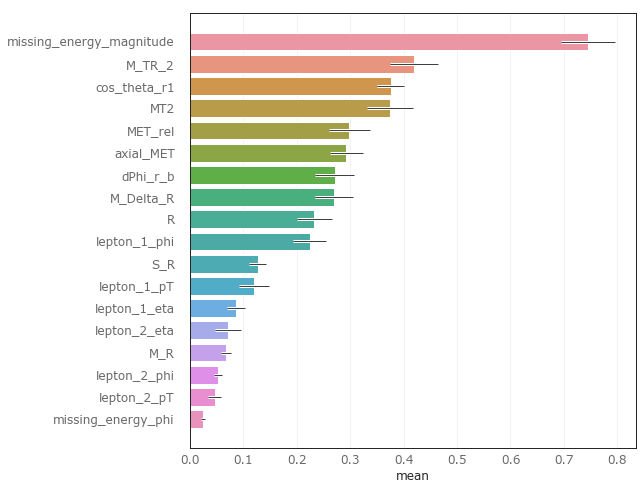

In [29]:
sns.barplot(sm_s_mean["mean"], sm_s_mean.index)
plt.errorbar(y=range(len(sm_s_mean)), x=sm_s_mean['mean'], xerr=sm_s_mean["statistical_uncertainty"], fmt='none', linewidth=3, c='w')
plt.errorbar(y=range(len(sm_s_mean)), x=sm_s_mean['mean'], xerr=sm_s_mean["statistical_uncertainty"], fmt='none', c='black')
plt.show();

In [30]:
means                     = np.mean(sm_b.query("classification==0").drop(["classification"], axis=1)[:50])
statistical_uncertainties = stats.sem(sm_b.query("classification==0").drop(["classification"], axis=1)[:50])

sm_b_mean = pd.DataFrame(means)
sm_b_mean.columns = ["mean"]
sm_b_mean["statistical_uncertainty"] = statistical_uncertainties
sm_b_mean = sm_b_mean.sort_values(by="mean", ascending=False)
sm_b_mean

,mean,statistical_uncertainty
R,0.682219,0.052051
cos_theta_r1,0.457578,0.038438
lepton_1_eta,0.451412,0.052467
MT2,0.420391,0.033173
dPhi_r_b,0.416345,0.045540
lepton_1_phi,0.371445,0.040643
axial_MET,0.353340,0.041035
lepton_2_eta,0.313689,0.040171
M_TR_2,0.260070,0.034297
missing_energy_magnitude,0.201645,0.016621


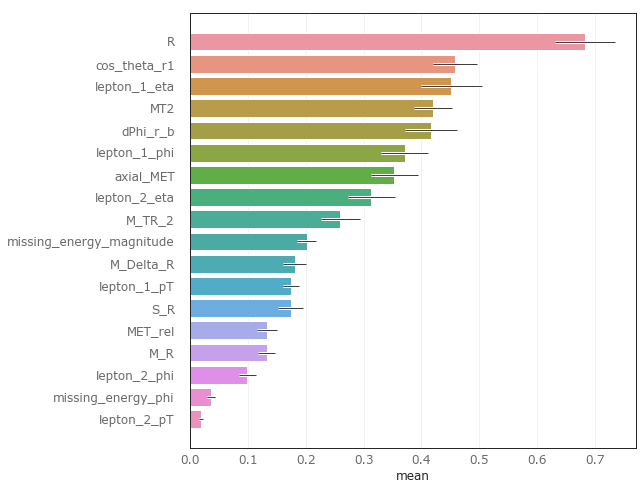

In [31]:
sns.barplot(sm_b_mean["mean"], sm_b_mean.index)
plt.errorbar(y=range(len(sm_b_mean)), x=sm_b_mean['mean'], xerr=sm_b_mean["statistical_uncertainty"], fmt='none', linewidth=3, c='w')
plt.errorbar(y=range(len(sm_b_mean)), x=sm_b_mean['mean'], xerr=sm_b_mean["statistical_uncertainty"], fmt='none', c='black')
plt.show();

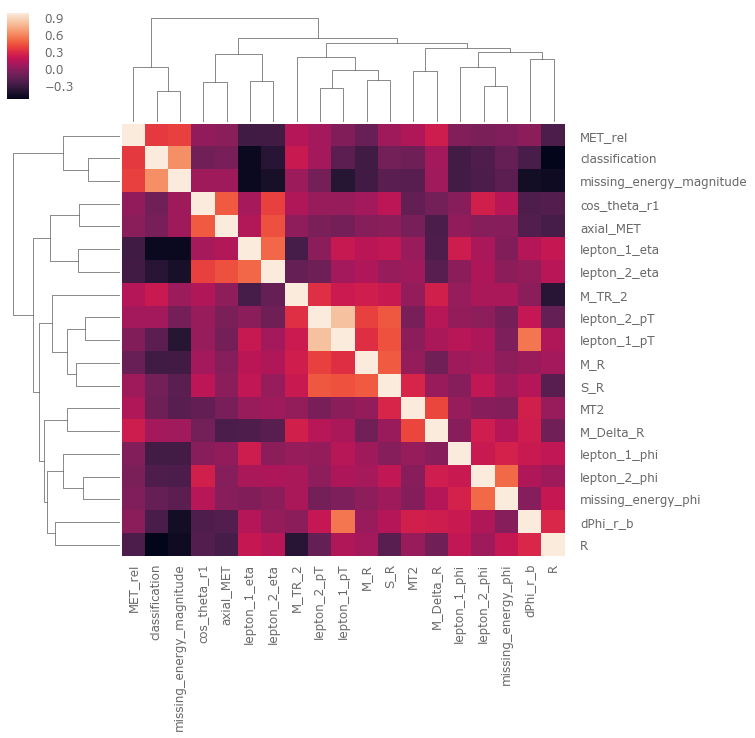

In [32]:
plot = sns.clustermap(sm_s.corr())
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)

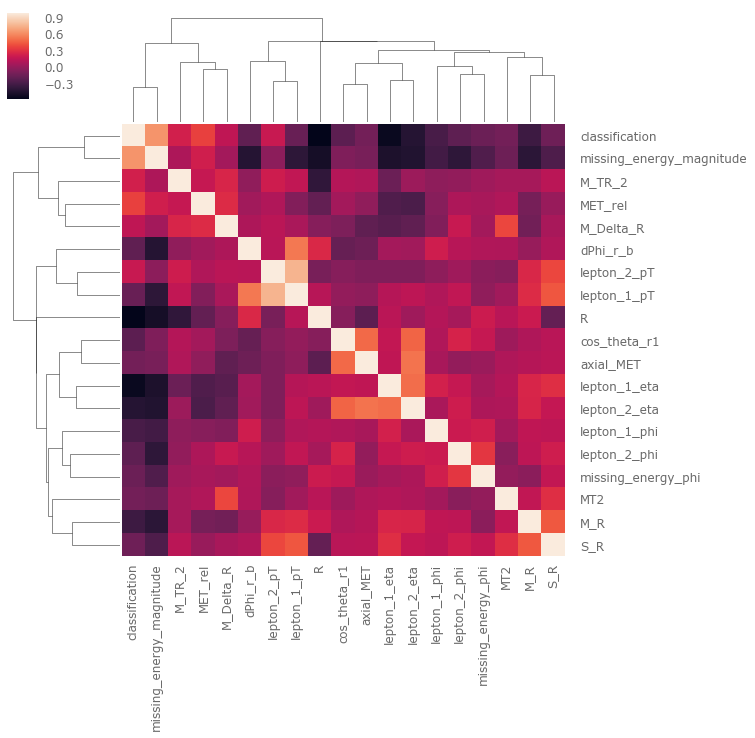

In [33]:
plot = sns.clustermap(sm_b.corr())
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)